In [1]:
%matplotlib inline

from __future__ import print_function

import math
import cmath
import re
import os
import glob
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.python.data import Dataset
import seaborn as sns
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# DEBUGGING AND OUTPUT
PLOT = True
SUMMARIZE = True
TEST = False

# NOTES
NOTES = "mobilenetv2-96"

# Vars
target_label = "label"
id_label = "ImageId"
TYPE = "CNN"
OUTSTR = "A{:.4f}_Type{}_LR{}_S{}_B{}{}.csv"
if TEST:
    LEARNING_STEPS = 100
    LEARNING_RATE = 0.01
    BATCH_SIZE = 10
else:
    LEARNING_STEPS = 250
    LEARNING_RATE = 0.01
    BATCH_SIZE = 100

# PATHS
paths = {
    "Training":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/train.csv",
    "Testing":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/test.csv",
    "Submission":"/home/wesleytocs/.kaggle/competitions/digit-recognizer/sample_submission.csv",
}

In [2]:
def adjust_image(data):
    # Reshape to [batch, height, width, channels].
    imgs = tf.reshape(data, [-1, 28, 28, 1])
    # Adjust image size to Inception-v3 input.
    imgs = tf.image.resize_images(imgs, (96, 96))
    # Convert to RGB image.
    imgs = tf.image.grayscale_to_rgb(imgs)
    return imgs

def display(img, w, h):
    one_image = img.reshape(w,h)
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)
    plt.show()

def mobilenet_model_fn(features, labels, mode):
    # Load mobilenet-v2 model.
    module = hub.Module("https://tfhub.dev/google/imagenet/mobilenet_v2_035_96/classification/1")
    input_layer = adjust_image(features["x"])
    outputs = module(input_layer)

    logits = tf.layers.dense(inputs=outputs, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    predictions["loss"] = loss

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=LEARNING_RATE)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

def train_nn_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    
    periods = steps // 100
    steps_per_period = steps // periods  
    
    predict_training_input_fn = create_predict_input_fn(
        training_examples, training_targets, batch_size)
    predict_validation_input_fn = create_predict_input_fn(
        validation_examples, validation_targets, batch_size)
    training_input_fn = create_training_input_fn(
        training_examples, training_targets, batch_size)
    
    my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.DNNClassifier(
        feature_columns=construct_feature_columns(),
        n_classes=10,
        hidden_units = hidden_units,
        optimizer=my_optimizer,
        config=tf.estimator.RunConfig(keep_checkpoint_max=1)
    )

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...\nMetrics:")
    print("\tPERIOD\tTYPE\tTRAIN.\tVALID.")
    training_accuracies = []
    validation_accuracies = []
    training_errors = []
    validation_errors = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # Take a break and compute probabilities.
        training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
        training_probabilities = np.array([item['probabilities'] for item in training_predictions])
        training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
        training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
        training_targets_one_hot = tf.keras.utils.to_categorical(training_targets,10)

        validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
        validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
        validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
        validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)  
        validation_targets_one_hot = tf.keras.utils.to_categorical(validation_targets,10)  

        # Compute training and validation errors.
        training_log_loss = log_loss(training_targets, training_pred_one_hot)
        validation_log_loss = log_loss(validation_targets, validation_pred_one_hot)
        training_accuracy = 100 * accuracy_score(training_targets_one_hot, training_pred_one_hot)
        validation_accuracy = 100 * accuracy_score(validation_targets_one_hot, validation_pred_one_hot)
        # Occasionally print the current loss.
        print("\t{}\tLgLs\t{:.2f}\t{:.2f}".format(period, training_log_loss, validation_log_loss))
        print("\t\tAcc.\t{:.2f}%\t{:.2f}%\n".format(training_accuracy, validation_accuracy))
        # Add the loss metrics from this period to our list.
        training_errors.append(training_log_loss)
        validation_errors.append(validation_log_loss)
        training_accuracies.append(training_accuracy)
        validation_accuracies.append(validation_accuracy)
    print("Model training finished.")
    # Remove event files to save disk space.
    _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))

    # Calculate final predictions (not probabilities, as above).
    final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])


    accuracy = 100 * accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): {:.4f}%".format(accuracy))

    # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.plot(training_errors, label="training")
    plt.plot(validation_errors, label="validation")
    plt.legend()
    plt.show()
    
    # Output a graph of loss metrics over periods.
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Accuracy vs. Periods")
    plt.plot(training_accuracies, label="training")
    plt.plot(validation_accuracies, label="validation")
    plt.legend()
    plt.show()

    # Output a plot of the confusion matrix.
    cm = confusion_matrix(validation_targets, final_predictions)
    # Normalize the confusion matrix by row (i.e by the number of samples
    # in each class).
    cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    ax = sns.heatmap(cm_normalized, cmap="bone_r")
    ax.set_aspect(1)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()
    return (classifier, accuracy)

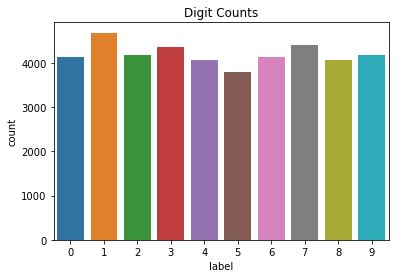

In [3]:
train_data = pd.read_csv(paths["Training"], sep=",").astype(np.int32)
if TEST:
    train_data = train_data.head(1000)
train_data = train_data.reindex(np.random.permutation(train_data.index))
ax = sns.countplot(x="label", data=train_data)
ax.set_title("Digit Counts")
train_labels = np.asarray(train_data.pop(target_label), dtype=np.int32)
train_data = train_data / 255
train_data = np.asarray(train_data, dtype=np.float32)

t_size = int(0.8 * train_data.shape[0])

validation_data = train_data[t_size:]
validation_labels = train_labels[t_size:]
train_data = train_data[:t_size]
train_labels = train_labels[:t_size]

eval_data = pd.read_csv(paths["Testing"], sep=",")
eval_labels = pd.read_csv(paths["Submission"], sep=",")["Label"]
if TEST:
    eval_data = eval_data.head(1000)
    eval_labels = eval_labels.head(1000)
eval_data = eval_data / 255
eval_data = np.asarray(eval_data, dtype=np.float32)
eval_labels = np.asarray(eval_labels, dtype=np.int32)

In [4]:
print("TRAINING")
print(train_data.shape)
print(train_labels.shape)
print("-" * 40)
print("VALIDATION")
print(validation_data.shape)
print(validation_labels.shape)
print("-" * 40)
print("EVALUATION")
print(eval_data.shape)
print(eval_labels.shape)
print(set(eval_labels))

TRAINING
(33600, 784)
(33600,)
----------------------------------------
VALIDATION
(8400, 784)
(8400,)
----------------------------------------
EVALUATION
(28000, 784)
(28000,)
{0}


In [5]:
# Create the Estimator
# classifier = tf.estimator.Estimator(
#     model_fn=mobilenet_model_fn, model_dir="/tmp/convnet_model")

In [6]:
# Train the model
# train_input_fn = tf.estimator.inputs.numpy_input_fn(
#     x={"x": train_data},
#     y=train_labels,
#     batch_size=BATCH_SIZE,
#     num_epochs=None,
#     shuffle=True)

# training_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
#     x={"x": train_data},
#     y=train_labels,
#     num_epochs=1,
#     shuffle=False)

# validation_eval_input_fn = tf.estimator.inputs.numpy_input_fn(
#     x={"x": validation_data},
#     y=validation_labels,
#     num_epochs=1,
#     shuffle=False)

In [7]:
layers = 3
units = [nearest_2(math.ceil(t_size ** (1/i))) for i in range(2, 2+layers)]
print(units)
unitstr = "_".join([str(x) for x in units])

classifier, accuracy = train_nn_classification_model(
    learning_rate=LEARNING_RATE,
    steps=LEARNING_STEPS,
    hidden_units=units,
    batch_size=BATCH_SIZE,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print("Final accuracy on validation set: {:.2f}%".format(accuracy * 100))

NameError: name 'nearest_2' is not defined

In [ ]:
#tensors_to_log = {"loss": loss, "accuracy" : accuracy}
# logging_hook = tf.train.LoggingTensorHook({"loss" : "loss"}, every_n_iter=10)

In [ ]:
# periods = LEARNING_STEPS // 5
# steps_per_period = LEARNING_STEPS // periods
# t_accs = []
# v_accs = []
# t_lls = []
# v_lls = []
# print("Training model...\nMetrics:")
# print("\tPERIOD\tTYPE\tTRAIN.\tVALID.")
# for period in range(periods):
# classifier.train(
#     input_fn=train_input_fn,
#     steps=LEARNING_STEPS,
#     hooks=[logging_hook])
#     training_stats = classifier.evaluate(input_fn=training_eval_input_fn)
#     validation_stats = classifier.evaluate(input_fn=validation_eval_input_fn)
#     t_ll = training_stats["loss"]
#     t_acc = 100 * training_stats["accuracy"]
#     v_ll = validation_stats["loss"]
#     v_acc = 100 * validation_stats["accuracy"]
#     print("\t{}\tLgLs\t{:.2f}\t{:.2f}".format(period, t_ll, v_ll))
#     print("\t\tAcc.\t{:.2f}%\t{:.2f}%\n".format(t_acc, v_acc))
#     t_lls.append(t_ll);
#     v_lls.append(v_ll)
#     t_accs.append(t_acc)
#     v_accs.append(v_acc)
# accuracy = classifier.evaluate(input_fn=validation_eval_input_fn)["accuracy"] * 100

In [9]:
print("Final accuracy (on validation data): {:.4f}%".format(accuracy))

# # Output a graph of loss metrics over periods.
# plt.ylabel("LogLoss")
# plt.xlabel("Periods")
# plt.title("LogLoss vs. Periods")
# plt.plot(t_lls, label="training")
# plt.plot(v_lls, label="validation")
# plt.legend()
# plt.show()

# # Output a graph of accuracy over periods.
# plt.ylabel("Accuracy")
# plt.xlabel("Periods")
# plt.title("Accuracy vs. Periods")
# plt.plot(t_accs, label="training")
# plt.plot(v_accs, label="validation")
# plt.legend()
# plt.show()

Final accuracy (on validation data): 93.2262%


In [10]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
stats = classifier.evaluate(input_fn=eval_input_fn)
t_accuracy = 100 * stats["accuracy"]
print("Accuracy on evaluation data (expected ~10%): {:.2f}%".format(t_accuracy))

Accuracy on evaluation data (expected ~10%): 9.91%


In [11]:
# Make Predictions and output the results
predictions = np.array([item['classes'] for item in classifier.predict(input_fn=eval_input_fn)])
ids = np.array([i + 1 for i in range(len(predictions))])
output = pd.DataFrame({id_label:ids, target_label:predictions}, dtype=np.int32)

In [12]:
if not TEST:
    name = OUTSTR.format(accuracy, TYPE, LEARNING_RATE, LEARNING_STEPS, BATCH_SIZE,"_" + NOTES if NOTES else "")
    print("Outputting to: '{}'".format(name))
    output.to_csv(name, index=False)

Outputting to: 'A93.2262_TypeCNN_LR0.01_S250_B100_mobilenetv2-96.csv'
